In [1]:
import torch
import torch.nn as nn
import pynq
import numpy as np
import torchsummary
import time

from torch import Tensor
from torch.nn import functional as F
from torch.nn import init
from torch.nn.parameter import Parameter
from torchvision.models import ResNet18_Weights

from itertools import repeat
from typing import Any, Callable, List, Optional, Type, Union, Tuple

from resnet18_fp32 import MyConv2d 
from matplotlib import pyplot as plt

/home/dpan/.conda/envs/pynq/lib/python3.9/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/home/dpan/.conda/envs/pynq/lib/python3.9/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


using kernel: <pynq.overlay.DefaultIP object at 0x7f78a6495c10>


In [2]:
fpga_times = []
ref_times = []
for BATCH_SIZE in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    IN_CHANNELS = 512
    OUT_CHANNELS = 512
    KERNEL_SIZE = 3
    # BATCH_SIZE = 16
    H = 22
    W = 22

    dummy_input = torch.rand(torch.Size([BATCH_SIZE, IN_CHANNELS, H, W]), dtype=torch.float32)
    weight = nn.Parameter(torch.rand(torch.Size([OUT_CHANNELS, IN_CHANNELS, KERNEL_SIZE, KERNEL_SIZE])))


    myconv = MyConv2d(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, bias=None, dtype=torch.float32)
    refconv = nn.Conv2d(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, bias=None, dtype=torch.float32)
    myconv.weight = weight
    refconv.weight = weight

    start = time.time()
    myconv(dummy_input)
    fpga_time = time.time() - start

    start = time.time()
    refconv(dummy_input)
    ref_time = time.time() - start

    fpga_times.append(fpga_time)
    ref_times.append(ref_time)

[0.05086469650268555, 0.09177899360656738, 0.1452932357788086, 0.2097463607788086, 0.3736734390258789, 0.7046897411346436, 1.4435787200927734, 2.89201283454895, 5.740018129348755, 11.566407203674316]
[0.003242969512939453, 0.005326747894287109, 0.010039329528808594, 0.017348289489746094, 0.03414654731750488, 0.11141681671142578, 0.20496392250061035, 0.38542628288269043, 0.7397196292877197, 1.1512682437896729]


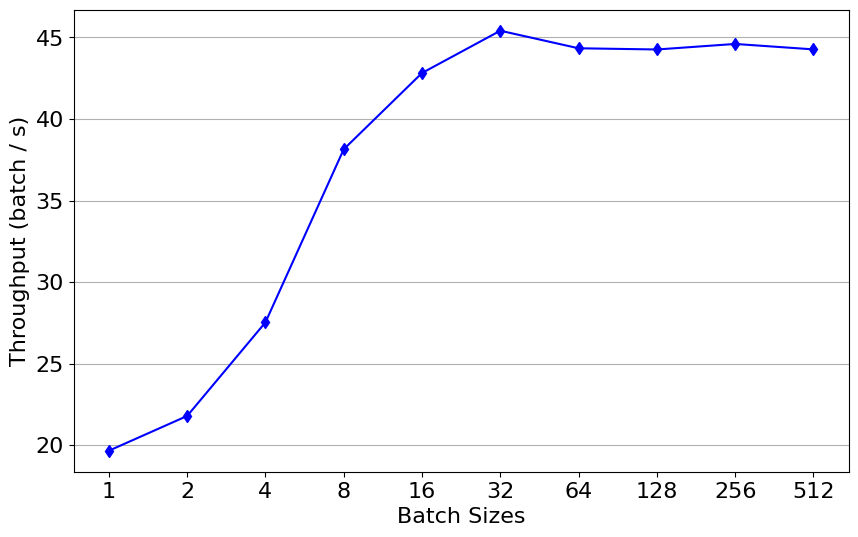

In [46]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mticker


print(fpga_times)
print(ref_times)
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
throughput = [size / time for time, size in zip(fpga_times, batch_sizes)]
widths = np.diff(throughput + [throughput[-1] * 2])

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.xscale('log', base=2)
plt.plot(batch_sizes, throughput, color='blue', marker='d')
plt.xlabel('Batch Sizes', fontsize=16)
plt.ylabel('Throughput (batch / s)', fontsize=16)
plt.xticks(batch_sizes, fontsize=16)
plt.yticks(None, fontsize=16)
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())

plt.grid(axis='y')

# Display the graph
plt.show()

In [4]:
print(np.array(fpga_times) / np.array(ref_times))

[ 8.27372563  8.90758936  8.10356966  6.96004427  6.34590282  6.09370548
  6.66311841  9.1274455  10.79529344 10.74957291]


In [5]:
from resnet18_fp32 import myresnet18
from torchvision.models import ResNet18_Weights, resnet18

weights = ResNet18_Weights.IMAGENET1K_V1

model = myresnet18(weights=weights, progress=False)

model2 = resnet18(weights=weights, progress=False)

fpga_times = []
ref_times = []
for BATCH_SIZE in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    dummy_input = torch.rand(BATCH_SIZE, 3, 224, 224, dtype=torch.float32)

    start = time.time()
    out = model(dummy_input)
    elapsed1 = time.time() - start

    start = time.time()
    out2 = model2(dummy_input)
    elapsed2 = time.time() - start

    assert out.shape == out2.shape
    verify = torch.all(out.isclose(out2, atol=1e-4))
    # print(f"Verify result: {verify}")
    assert verify
    # print(weights.meta['categories'][out.argmax(dim=1)], target)
    # print(f"time1 = {elapsed1}, time2 = {elapsed2}")
    fpga_times.append(elapsed1)
    ref_times.append(elapsed2)

    # print("Done")

nn.Linear: torch.Size([1, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([2, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([4, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([8, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([16, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([32, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([64, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([128, 512]) torch.Size([1000, 512])
nn.Linear: torch.Size([256, 512]) torch.Size([1000, 512])


In [6]:
print(np.array(fpga_times) / np.array(ref_times))

[28.20765557 23.41049215 30.24365928 26.98937961 23.80434538 22.67492012
 21.37938894 21.34748738 21.20933481]


[0.47684812545776367, 0.6870245933532715, 1.0930213928222656, 1.7656276226043701, 3.486504077911377, 6.538829565048218, 12.845898151397705, 26.24000573158264, 53.3601016998291]
[0.01914072036743164, 0.02883625030517578, 0.045427560806274414, 0.09077906608581543, 0.14580225944519043, 0.4447610378265381, 0.8094437122344971, 1.5671660900115967, 2.8187005519866943]


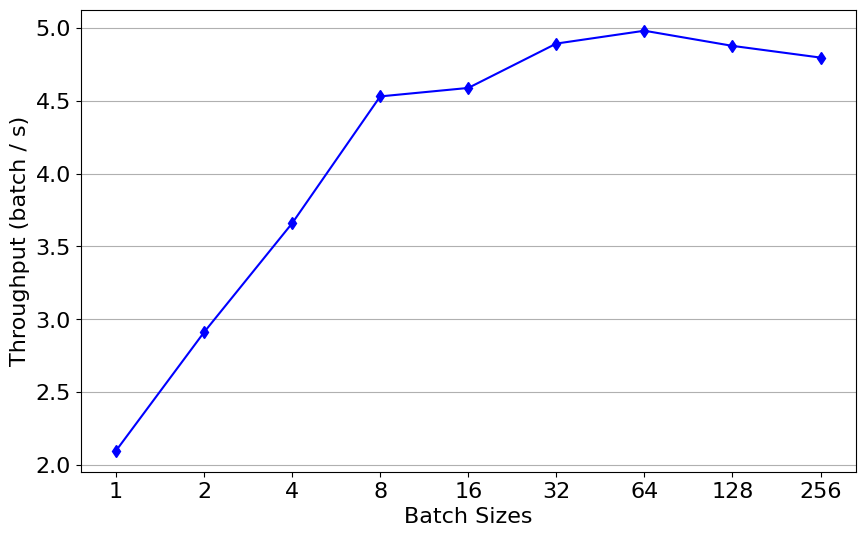

In [55]:
# fpga_times[-1] = 168.44419527053833 # time1 = 168.44419527053833, time2 = 6.50303840637207
print(fpga_times)
print(ref_times)
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
throughput = [size / time for time, size in zip(fpga_times, batch_sizes)]
widths = np.diff(throughput + [throughput[-1] * 2])

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.xscale('log', base=2)
plt.plot(batch_sizes, throughput, color='blue', marker='d')
plt.xlabel('Batch Sizes', fontsize=16)
plt.ylabel('Throughput (batch / s)', fontsize=16)
plt.xticks(batch_sizes, fontsize=16)
plt.yticks(None, fontsize=16)
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())

plt.grid(axis='y')

# Display the graph
plt.show()

[0.056202215634264314, 0.09463774899880377, 0.09001404275237947, 0.7533260519061736, 0.005819940708378843]


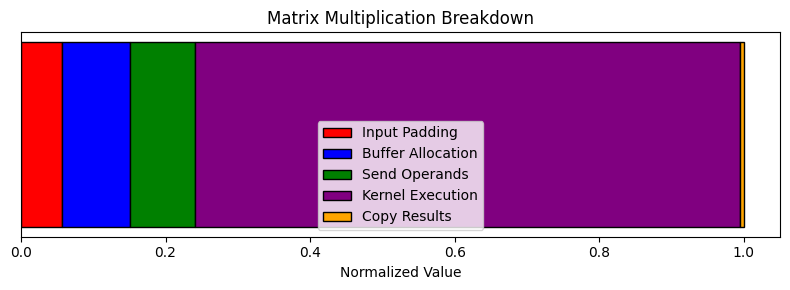

In [2]:
# Adjusting the visualization to make the bar not as tall on the y-axis
values = 0.0025763511657714844, 0.004338264465332031, 0.004126310348510742, 0.034533023834228516, 0.00026679039001464844
normalized_values = [val / sum(values) for val in values]
colors = ['red', 'blue', 'green', 'purple', 'orange']
print(normalized_values)


segment_names = ['Input Padding', 'Buffer Allocation', 'Send Operands', 'Kernel Execution', 'Copy Results']

plt.figure(figsize=(8, 3))  # Adjusting figure size for a less tall y-axis
left = 0  # Start point for the first segment
for idx, val in enumerate(normalized_values):
    plt.barh(0.5, val, left=left, color=colors[idx], edgecolor='black', height=0.3, label=segment_names[idx])
    left += val  # Update the start point for the next segment

plt.title('Matrix Multiplication Breakdown')
plt.xlabel('Normalized Value')
plt.yticks([])  # Hide y-axis ticks
plt.legend()
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

[0.11583622315507697, 0.04611547119304009, 0.0736892844941759, 0.07969824177161282, 0.6775146129042825, 0.006579901816258816, 0.0005662646655528568]


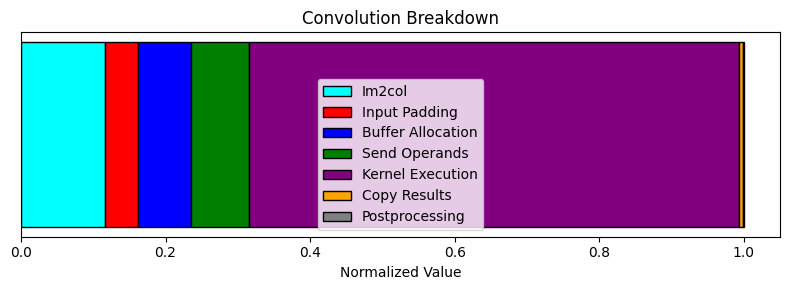

In [3]:
# Adjusting the visualization to make the bar not as tall on the y-axis
values = [0.005901336669921875, 0.002349376678466797, 0.003754138946533203, 0.004060268402099609, 0.034516334533691406, 0.0003352165222167969, 2.8848648071289062e-05]
normalized_values = [val / sum(values) for val in values]
print(normalized_values)
colors = ['cyan', 'red', 'blue', 'green', 'purple', 'orange', 'grey']


segment_names = ['Im2col', 'Input Padding', 'Buffer Allocation', 'Send Operands', 'Kernel Execution', 'Copy Results', 'Postprocessing']

plt.figure(figsize=(8, 3))  # Adjusting figure size for a less tall y-axis
left = 0  # Start point for the first segment
for idx, val in enumerate(normalized_values):
    plt.barh(0.5, val, left=left, color=colors[idx], edgecolor='black', height=0.3, label=segment_names[idx])
    left += val  # Update the start point for the next segment

plt.title('Convolution Breakdown')
plt.xlabel('Normalized Value')
plt.yticks([])  # Hide y-axis ticks
plt.legend()
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

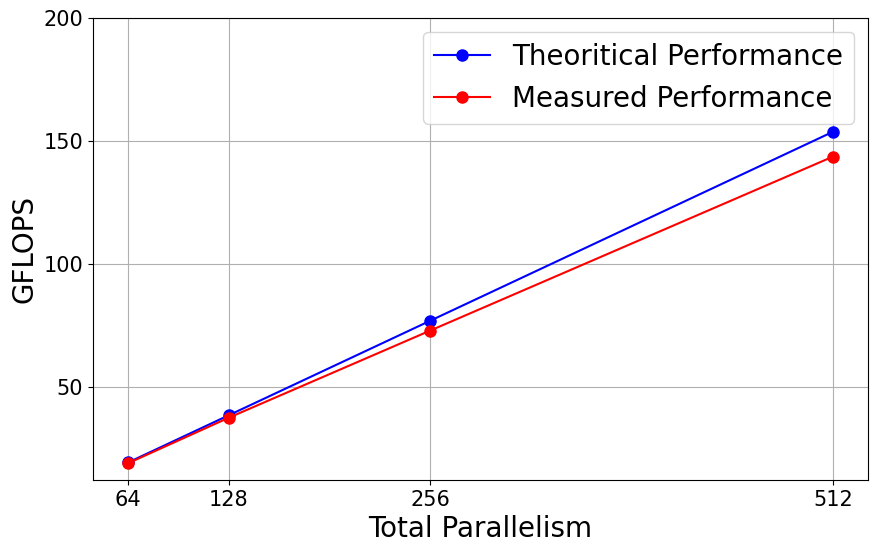

In [7]:
# Example data for the plot
x = [64, 128, 256, 512]  # X coordinates
y1 = [19.2, 38.4, 76.8, 153.6] # Data for the first line
y2 = [18.9, 37.4, 72.8, 143.5] # Data for the second line

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y1, 'bo-', label='Theoritical Performance', markersize=8) # Blue line with round dots
plt.plot(x, y2, 'ro-', label='Measured Performance', markersize=8)  # Red line with round dots
plt.xlabel('Total Parallelism', fontsize=20)
plt.ylabel('GFLOPS', fontsize=20)
plt.xticks(x, fontsize=15)
plt.yticks([50, 100, 150, 200], fontsize=15)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()